In [1]:
import random
import gym
import numpy as np
from tqdm import tqdm
from agent import DQN_agent
from memory import ReplayBuffer
import torch
import utils
import matplotlib.pyplot as plt
from IPython.display import HTML, display
%matplotlib inline

In [2]:
lr = 2e-3
num_iter = 10
num_episodes = 5000
warmup_episodes = 10
gamma = 0.98
epsilon = 1
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
seed = 123

In [3]:
env_name = 'Taxi-v3'
env = gym.make(env_name, render_mode="rgb_array")

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.n
action_dim = env.action_space.n

agent = DQN_agent(state_dim, action_dim, gamma, lr,
            epsilon, target_update, device)

In [4]:
rewards_list = []
durations_list = []
epsilon_list = []
for i in range(num_iter):
    with tqdm(total=int(num_episodes / num_iter), desc='Iteration %d' % (i+1)) as pbar:
        for i_episode in range(int(num_episodes / num_iter)):
            episode_rewards = 0
            episode_durations = 0
            state, _ = env.reset()
            encoded_state = utils.encode_state(state)
            done = False
            
            if i_episode >= warmup_episodes:
                agent.decay_epsilon(i_episode, decay_rate=0.01)
            
            epsilon_list.append(agent.epsilon)    
            while not done:
                action = agent.take_action(encoded_state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                
                taxi_row, taxi_col, passenger_location, destination = env.decode(next_state)
                
                '''reward shaping'''
                # 如果agent接到乘客或者agent将乘客送达，在原来的reward基础上根据步长奖励
                if (passenger_location == 4 and action == 4 and reward == -1) or reward == 20:
                    reward += 0.05 * (200 - episode_durations)
                
                done = terminated or truncated
                encoded_next_state = utils.encode_state(next_state)
                
                replay_buffer.add(encoded_state, action, reward, encoded_next_state, done)
                
                state = next_state
                encoded_state = encoded_next_state
                episode_rewards += reward
                episode_durations += 1
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    state_batch, action_batch, reward_batch, next_state_batch, done_batch = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': state_batch,
                        'actions': action_batch,
                        'next_states': next_state_batch,
                        'rewards': reward_batch,
                        'dones': done_batch
                    }
                    agent.update(transition_dict)

            rewards_list.append(episode_rewards)
            durations_list.append(episode_durations)
            if (i_episode + 1) % num_iter == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / num_iter * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(rewards_list[-num_iter:])
                })
            pbar.update(1)
print("complete the training of DQN agent!")

agent.save(f"./model/DQN_taxi_agent.pth")

Iteration 10: 100%|██████████| 500/500 [00:24<00:00, 20.52it/s, episode=5000, return=8.900]  

complete the training of DQN agent!


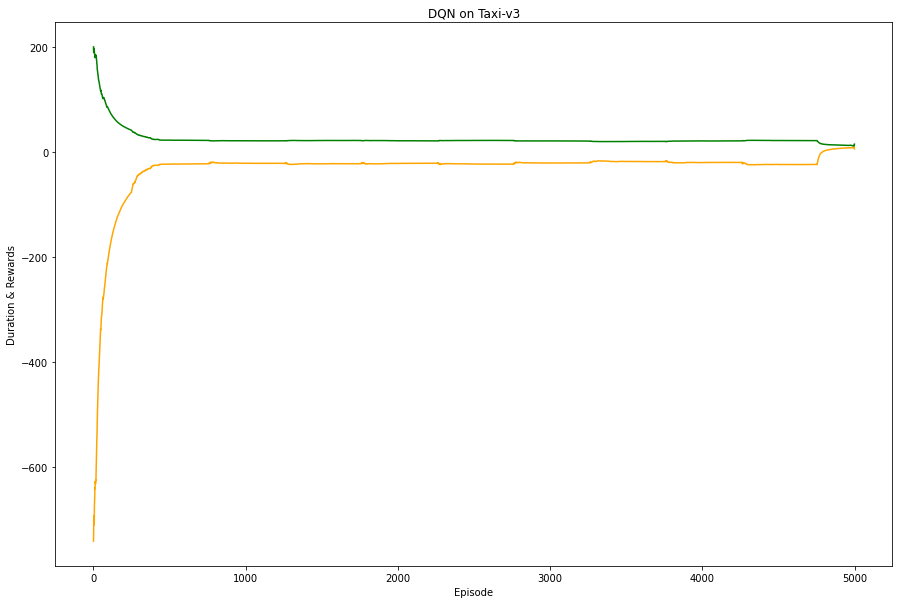

In [7]:
fig = plt.figure(1, figsize=(12, 12))

episodes_list = list(range(len(rewards_list)))
mv_rewards = utils.moving_average(rewards_list, 499)
mv_durations = utils.moving_average(durations_list, 499)
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.plot(episodes_list, mv_rewards, color='orange', label='Rewards')

plt.title('DQN on {}'.format(env_name))

plt.show()

In [ ]:
fig = plt.figure(1, figsize=(12, 12))

plt.xlabel('Episode')
plt.ylabel('Durations')
plt.plot(episodes_list, mv_durations, color='green', label='Durations')

plt.title('DQN on {}'.format(env_name))

plt.show()

In [ ]:
for i in range(10):
    animation = agent.play(env, save_path='./animation/game_animation_%d.mp4' % (i + 1))

In [10]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [11]:
def show_state(env, step, reward):
    plt.figure(1)
    plt.clf()
    plt.imshow(env.render())
    plt.title("Step: %d, reward=%d" % (step, reward))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.pause(0.01)

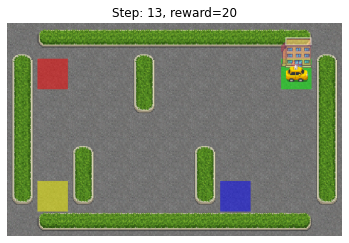

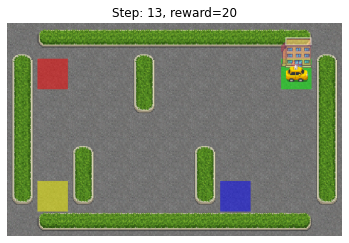

done!
14


In [13]:
state, _ = env.reset()
encoded_state = utils.encode_state(state)
done = False
step = 0
rewards = 0
while not done:
    action = agent.take_action(encoded_state, mode='eval')
    next_state, reward, terminated, truncated, _ = env.step(action)
    show_state(env,step,reward)
    step += 1
    rewards += reward
    encoded_next_state = utils.encode_state(next_state)
    done = terminated or truncated

    state = next_state
    encoded_state = encoded_next_state
    
print('done!')
print(step)

env.close()